# PipLine of Submission

- model part: 'train' data loading, model training
- predict: prediction result
- save: save prediction in appropriate format

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

from utils import helper
from utils import DataLoader, DataProcesser

%load_ext autoreload
%autoreload 2

# Data

- combine train dataset & validate dataset to new 'train' data

In [2]:
data_df = pd.read_csv('data/mid_res/20210526_data_df.csv')
val_df = pd.read_csv('data/mid_res/20210526_val_df.csv')
df = pd.concat([data_df, val_df], axis = 0)

In [3]:
col_drop_x = ['time', 'label']
col_label = 'label'
col_drop = ['latitude',
 'longitude',
 'altitude',
 'time_dlt',
 'valid_dlt',
 'east',
 'north',
 'east_dlt',
 'north_dlt',
 'east_speed',
 'north_speed',
 'cells_ctype_mode',
 'speed_dif',
 'speed_dlt',
 'speed'
 ]

In [4]:
test_ratio = 0.2
X = df.drop(col_drop_x + col_drop, axis = 1).fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, df[col_label], test_size = test_ratio, random_state = 999)

# Model

## Random Forest

In [5]:
model_rf = RandomForestClassifier(n_estimators = 20, random_state = 0, max_depth = 8)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test) # label predict
pred_prob_rf = model_rf.predict_proba(X_test) # prob predict

[[25755  2915    38   239   407  1317  2327  2034]
 [ 1108 23140  1500   936   184   407   164    88]
 [    7   429  5721   209    16    11     0     1]
 [  195   724  1584 21252  2564  1870   422   227]
 [   46    62    11   830 25956  2479  3325  1113]
 [  403   644   197  2013  3831 21520  4292  2162]
 [  885   572     5   100  3072  2357 23861  1776]
 [ 1753  1164     3   295    81   186  1275 20837]]
              precision    recall  f1-score   support

       Still       0.85      0.74      0.79     35032
     Walking       0.78      0.84      0.81     27527
         Run       0.63      0.89      0.74      6394
        Bike       0.82      0.74      0.78     28838
         Car       0.72      0.77      0.74     33822
         Bus       0.71      0.61      0.66     35062
       Train       0.67      0.73      0.70     32628
      Subway       0.74      0.81      0.77     25594

    accuracy                           0.75    224897
   macro avg       0.74      0.77      0.75    22

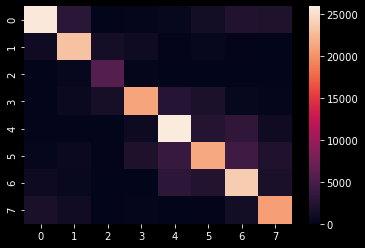

In [6]:
helper.evaluate(pred_rf, y_test)

## Bagging

In [7]:
model_bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 100, max_samples = 100, bootstrap=True)
model_bag.fit(X_train, y_train)
pred_bag = model_bag.predict(X_test)
pred_prob_bag = model_bag.predict_proba(X_test)

[[24866  3676    95   384   947  3755  4452  2674]
 [ 1313 22309  1739   845   221   650   282   232]
 [   32   936  5165   681    70   127    16    17]
 [  126   742  1985 20124  2320  2550   382   358]
 [   21   108     5  1507 25430  3341  6644  2476]
 [  276   376    59  1944  3698 15828  3497  1745]
 [ 1109   345     4    86  3312  3556 18446  2392]
 [ 2409  1158     7   303   113   340  1947 18344]]
              precision    recall  f1-score   support

       Still       0.82      0.61      0.70     40849
     Walking       0.75      0.81      0.78     27591
         Run       0.57      0.73      0.64      7044
        Bike       0.78      0.70      0.74     28587
         Car       0.70      0.64      0.67     39532
         Bus       0.53      0.58      0.55     27423
       Train       0.52      0.63      0.57     29250
      Subway       0.65      0.75      0.69     24621

    accuracy                           0.67    224897
   macro avg       0.67      0.68      0.67    22

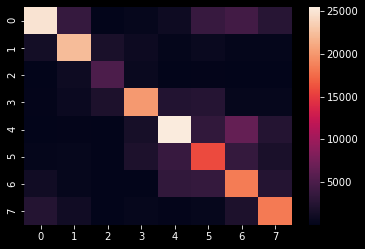

In [8]:
helper.evaluate(pred_bag, y_test)

## LightGBM

In [9]:
train_data = lgb.Dataset(X_train, label = y_train - 1)
test_data = lgb.Dataset(X_test, label = y_test - 1)
params={
    'learning_rate':0.1,
    'lambda_l1':0.1,
    'lambda_l2':0.2,
    'max_depth':6,
    'objective':'multiclass',
    'num_class':8,  
}
model_lgb = lgb.train(params, train_data, valid_sets = [test_data])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4967
[LightGBM] [Info] Number of data points in the train set: 899588, number of used features: 32
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -1.998039
[LightGBM] [Info] Start training from score -2.020589
[LightGBM] [Info] Start training from score -3.218668
[LightGBM] [Info] Start training from score -2.161786
[LightGBM] [Info] Start training from

In [10]:
pred_prob_lgb = model_lgb.predict(X_test)
pred_lgb = pred_prob_lgb.argmax(axis = 1) + 1

[[28834   487     2   172   103   216   312   188]
 [  443 27478   276   547    98   123    98    85]
 [    4   225  8330   289    20    19     5     0]
 [  147   387   414 24212  1046   343   128    30]
 [   32    40     4   458 33679  1650  1436   365]
 [   55   158    26   125   400 27200   672   257]
 [  204   270     4    50   690   549 32836   418]
 [  433   605     3    21    75    47   179 26895]]
              precision    recall  f1-score   support

       Still       0.96      0.95      0.95     30314
     Walking       0.93      0.94      0.93     29148
         Run       0.92      0.94      0.93      8892
        Bike       0.94      0.91      0.92     26707
         Car       0.93      0.89      0.91     37664
         Bus       0.90      0.94      0.92     28893
       Train       0.92      0.94      0.93     35021
      Subway       0.95      0.95      0.95     28258

    accuracy                           0.93    224897
   macro avg       0.93      0.93      0.93    22

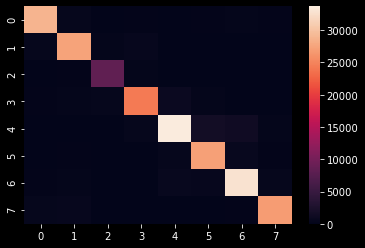

In [11]:
helper.evaluate(pred_lgb, y_test)

# Ensemble

In [12]:
def get_pred_mode(sr):
    ct = Counter(sr).most_common()[0]
    return ct[0] if ct[1] >= 2 else sr[2]


In [21]:
df_res = pd.DataFrame({"rf": pred_rf, "bag": pred_bag, "lgb": pred_lgb, "label": y_test})
df_res['pred'] = df_res.apply(lambda x: get_pred_mode(x[['rf', 'bag', 'lgb']]), axis = 1)

In [ ]:
helper.evaluate(df_res['pred'], df_res['label'])

# Test Data

In [41]:
# test = DataLoader.SHLDataLoader('data/test/', ratio = None)
# test.load_all()
# dp = DataProcesser.DataProcesser(test)
# dp.process_pipe()
# test_time = pd.read_table('data/example_submission/teamName_predictions.txt', header = None, names = ['time', 'label'], sep = "\t")['time']
# test.df = pd.merge(test_time, test.df, on = ['time'], how = 'left')
with open('data/mid_res/test.pickle', 'rb') as f:  
    test = pickle.load(f)

In [42]:
X_test2 = test.df.drop(['time'] + col_drop, axis = 1).fillna(0)

In [43]:
pred2_rf = pd.Series(model_rf.predict(X_test2))
pred2_bag = pd.Series(model_bag.predict(X_test2))
pred2_lgb = pd.Series(model_lgb.predict(X_test2).argmax(axis = 1) + 1)

In [25]:
pred2_prob_rf = model_rf.predict_proba(X_test2)
pred2_prob_bag = model_bag.predict_proba(X_test2)
pred2_prob_lgb = model_lgb.predict(X_test2)

In [37]:
# add prob + window mean
pred2_prob = pred2_prob_rf + pred2_prob_bag + pred2_prob_lgb
pred2_prob_mean = pd.DataFrame(pred2_prob).rolling(100, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')
pred2_mean = pd.Series(np.array(pred2_prob_mean).argmax(axis = 1) + 1)

In [ ]:
# hard voting
df_res = pd.DataFrame({"rf": pred2_rf, "bag": pred2_bag, "lgb": pred2_lgb})
df_res['pred'] = df_res.apply(get_pred_mode(x[['rf', 'bag', 'lgb']]), axis = 1)

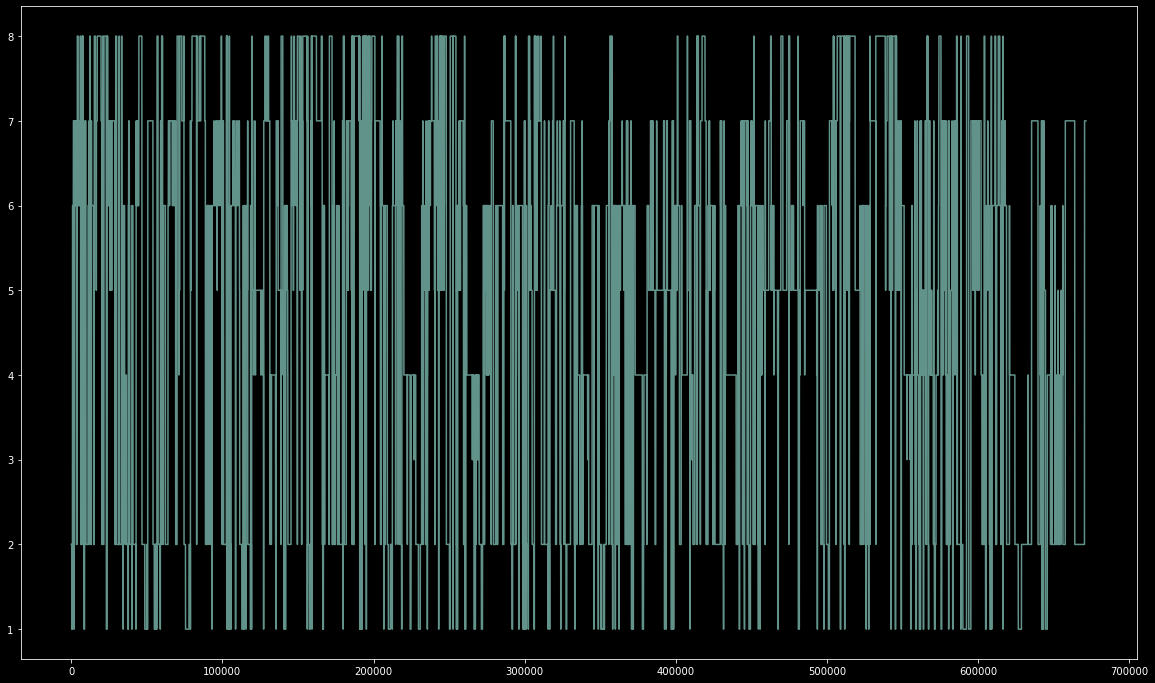

In [52]:
plt.figure(figsize = [20, 12])
plt.plot(df_res['pred_mode'], alpha = 0.7)

# Save Result

In [76]:
def save_prediction(pred_time, pred_res, file_path = 'data/RY_predictions.txt'):
    res = pd.DataFrame({'time': pred_time, 'label': pred_res})
    res.to_csv(file_path, index = False, header = False, sep = '\t')

In [75]:
# save_prediction(test.df.time, pred, 'data/RY_predictions.txt')